In [1]:
import configparser
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;plt.style.use('fivethirtyeight')
import seaborn as sns;

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report,mutual_info_score

import missingno as msno


In [2]:
# Configuration Parameters Initialization
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [3]:
################# PARAMETERS ###################################################

TARGET=config["EDA_TARGET"]["TARGET_NAME"]
POSITIVE_CLASS=config["EDA_TARGET"]["POSITIVE_CLASS"]

In [4]:
#################### Utils ######################################################

####################  Utility Functions ######################################################

def read_config(config_file="config.ini"):
    config = configparser.ConfigParser()
    config.read(config_file)
    return config

def import_data(filepath):
    '''
    returns dataframe for the csv found at filename_path

    input:
            filename_path (str): a path to the csv
            ex.: ./data/input_data.csv
    output:
            df: pandas dataframe
    '''

    df = pd.read_csv(filepath)

    return df


def split_data_target(target_col,filepath):
    '''
    split data and target columns from a dataframe at filename_path
    
    input:
            target_col (str): target column name
            filename_path (str): a path to the csv
            ex.: ./data/input_data.csv
            
    output:
            data: pandas dataframe excluding the target_col column.
            target: pandas series containing the target
    '''
    
    df=import_data(filepath)
    data,target=df.drop(target_col,axis=1),df[target_col]
    
    return data,target


def get_categorical(data,target):
    df=data.copy()
    config=read_config()
    categorical=[feature for feature in df if (df[feature].dtype=="object"
                or df[feature].nunique() < int(config["EDA_CATEGORICAL"]["CARDINALITY_THRESHOLD"]))
                and feature !=target]
    return categorical

def get_numerical(data,target):
    df=data.copy()
    cat=get_categorical(data,target)
    numerical = [feature for feature in df if feature not in cat and feature !=target]
    return numerical

def set_plot(plotsize=(15,7),
            title="",
            title_size=15,
            grid=False,
            ax=None,
            fig=None,
            xlabel="",
            ylabel="",
             **kwargs):
    
    if grid:
        ax.set_title(title + "\n",size=title_size)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.tight_layout()

    else:
        fig,ax = plt.subplots(1,1)
        fig.set_size_inches(plotsize)
        ax.set_title(title + "\n", size = title_size)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        fig.set_tight_layout(True)
        return fig,ax

def set_fig(gridsize=(15,7),gridtitle="",**kwargs):
    fig = plt.figure()
    fig.set_size_inches(gridsize)
    fig.suptitle(gridtitle + "\n", size = 20)
    return fig

def save_plot(fig,filename):
    config=read_config()
    fig.savefig(config["GENERAL"]["EDA_PATH"] + filename)

def set_subplots(data,target,features_type,ncols=3,**kwargs):
    if features_type.lower() == "categorical":
        features=get_categorical(data,target)
    elif features_type.lower() == "numerical":
        features=get_numerical(data,target)
        
    n_features= len(features)
    grid_cols = min(ncols,n_features)
    fig = set_fig(**kwargs)  
    
    return features,n_features,grid_cols,fig

def get_barplot(data,percentual=True):
    df=data.copy()
    if percentual:
        ax=df.sort_values().mul(100).plot(kind="barh")
    else:
        ax= df.sort_values().plot(kind="barh")
    
    return ax

def get_histogram(data):
    df=data.copy()
    ax=df.plot(kind="hist")
    
    return ax

def numericalize_target(data,target,positive_class):
    data[target] = (data[target] == positive_class).astype(int)
    return data[target]
    

#####################################################################################
   
############################# EDA ###############################################


def plot_distribution(data,
                      kind,
                      target=TARGET,
                      **kwargs):
    df=data.copy()
    config=read_config()
    fig,ax = set_plot(**kwargs)
    if kind.lower() =="target":
        bar_data= df[target].value_counts(normalize=True,dropna=False)
        ax=get_barplot(data=bar_data,percentual=True)
        save_plot(fig,config["EDA_TARGET"]["TARGET_DISTRIBUTION_FILENAME"])
    elif kind.lower() =="cardinality":
        categorical=get_categorical(df,target)
        bar_data= df[categorical].nunique()
        ax=get_barplot(data=bar_data,percentual=False)
        save_plot(fig,config["EDA_CATEGORICAL"]["CATEGORICAL_CARDINALITY_FILENAME"])
 
    
def plot_grid(data,
              plot_type,
              title_size=15,
              target=TARGET,
              positive_class=POSITIVE_CLASS,
              **kwargs):
    
    df=data.copy()
    config=read_config()
    
    if (plot_type.lower() == "rate") or (plot_type.lower() == "distribution"):
        features,n_plots,n_cols,fig = set_subplots(data,target,"categorical",**kwargs)
        df[target] = (df[target] == positive_class).astype(int)
        
    elif (plot_type.lower() == "strip") or (plot_type.lower() == "histogram"):
        features,n_plots,n_cols,fig = set_subplots(data,target,"numerical",**kwargs)
    
    for counter,feat in zip(range(1,n_plots+1),features):
        
        ax = fig.add_subplot(round(n_plots/n_cols),n_cols,counter)
        
        if plot_type.lower() =="rate":
            bar_data=df.groupby(feat)[target].mean()
            ax = get_barplot(data=bar_data)
            set_plot(grid=True,ax=ax,fig=fig,title=feat)
            filename=config["EDA_CATEGORICAL"]["CATEGORICAL_RATE_FILENAME"]
                        
        elif plot_type.lower() == "distribution":
            bar_data=df[feat].value_counts(normalize=True,dropna=False)
            ax = get_barplot(data=bar_data)
            set_plot(grid=True,ax=ax,fig=fig,title=feat)
            filename=config["EDA_CATEGORICAL"]["CATEGORICAL_DISTRIBUTION_FILENAME"]
                                               
        elif plot_type.lower()== "strip":
            ax = sns.stripplot(x=target, y=feat, data=df)
            set_plot(grid=True,ax=ax,fig=fig,title=feat)
            filename=config["EDA_NUMERICAL"]["STRIPPLOT_FILENAME"]
            
        elif plot_type.lower() == "histogram":
            ax = data[feat].plot(kind="hist")
            set_plot(grid=True,ax=ax,fig=fig,title=feat)
            filename=config["EDA_NUMERICAL"]["HISTOGRAM_FILENAME"]
                       
    save_plot(fig,filename)
    
       
def plot_target_correlations(data,
                            positive_class=POSITIVE_CLASS,
                            target=TARGET,
                            **kwargs):
    df=data.copy()
    config=read_config()
    df[target] = (df[target] == positive_class).astype(int)
    numerical=get_numerical(data,target)
    fig,ax = set_plot(**kwargs)
    ax = data[numerical].corrwith((data[target]==positive_class).astype(int)).sort_values().plot(kind="barh")
    save_plot(fig,config["EDA_TARGET"]["TARGET_CORRELATIONS_FILENAME"]) 
    
def plot_features_correlations(data,
                            positive_class=POSITIVE_CLASS,
                            target=TARGET,
                            annot=True,
                            **kwargs):
    df=data.copy()
    config=read_config()
    df[target] = (df[target] == positive_class).astype(int)
    numerical=get_numerical(data,target)
    midpoint=data[numerical].corr().mean().mean()
    fig,ax = set_plot(**kwargs)
    correlations = data[numerical + [target]].corr()
    non_exaustive_corr = np.triu(correlations)
    ax=sns.heatmap(correlations,cmap='Blues',mask=non_exaustive_corr,cbar=False,center=midpoint,annot=annot)
    save_plot(fig,config["EDA_NUMERICAL"]["NUMERICAL_FEATURES_CORRELATIONS_FILENAME"])

def run_eda():
    config=read_config()

    data = import_data(config["DATA"]["PATH"])

    plot_distribution(data=data,
                      kind="target",
                        title=config["EDA_TARGET"]["TARGET_DISTRIBUTION_TITLE"],
                        xlabel="% of observations",
                        )

    plot_target_correlations(data=data,
                            title=config["EDA_TARGET"]["TARGET_CORRELATIONS_TITLE"])

    plot_features_correlations(data=data,
                            title=config["EDA_NUMERICAL"]["NUMERICAL_FEATURES_CORRELATIONS_TITLE"],
                                )

    plot_distribution(data=data,
                      kind="cardinality",
                      title=config["EDA_CATEGORICAL"]["CATEGORICAL_CARDINALITY_TITLE"],
                            )

    plot_grid(data=data,
                        gridtitle=config["EDA_CATEGORICAL"]["GRID_TITLE"],
                        plot_type="Rate"
                        )

    plot_grid(data=data,
                        gridtitle=config["EDA_NUMERICAL"]["GRID_TITLE"],
                        plot_type="distribution",
                            )

    plot_grid(data=data,
                        plot_type="histogram",
                        gridtitle=config["EDA_NUMERICAL"]["HISTOGRAM_TITLE"])

            
    plot_grid(data=data,
                        plot_type="strip",
                        gridtitle=config["EDA_NUMERICAL"]["STRIPPLOT_TITLE"])


In [5]:
data = import_data(config["DATA"]["PATH"])
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## 1. EDA

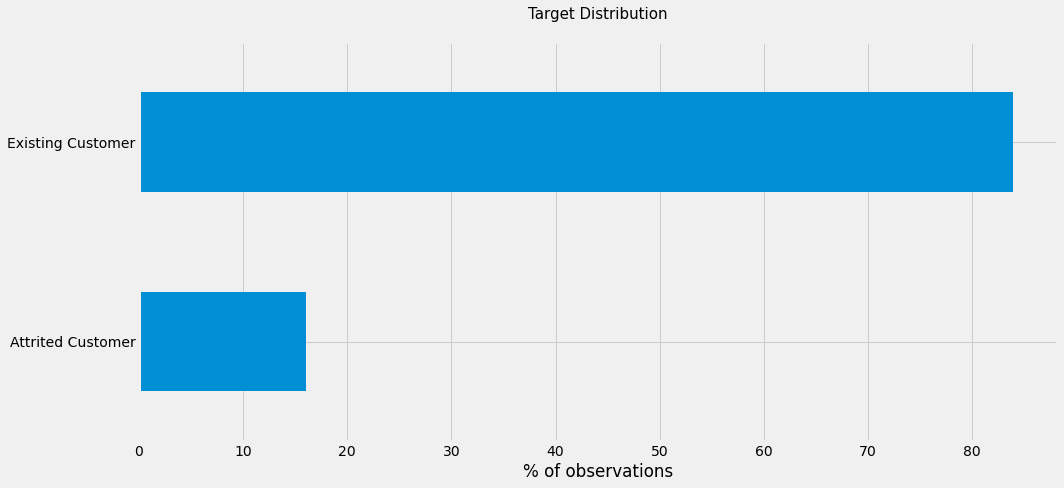

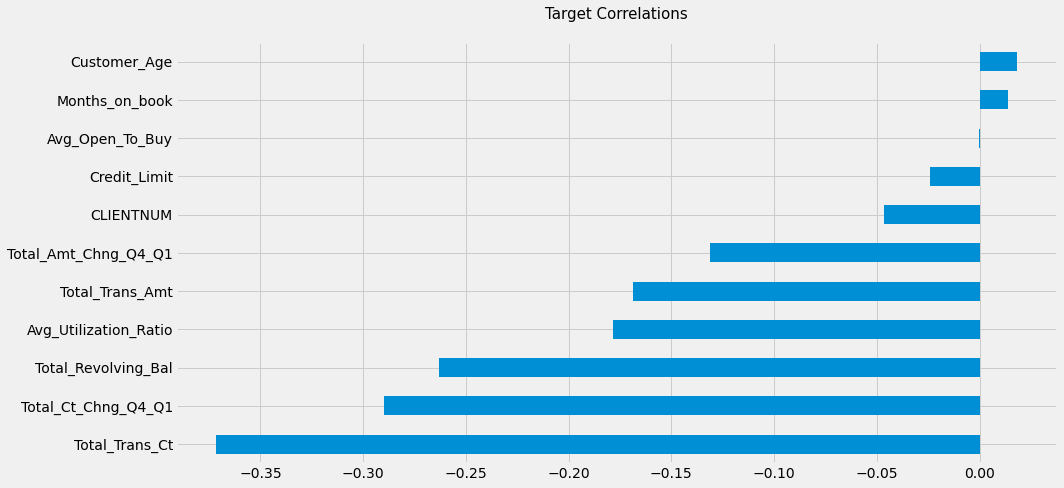

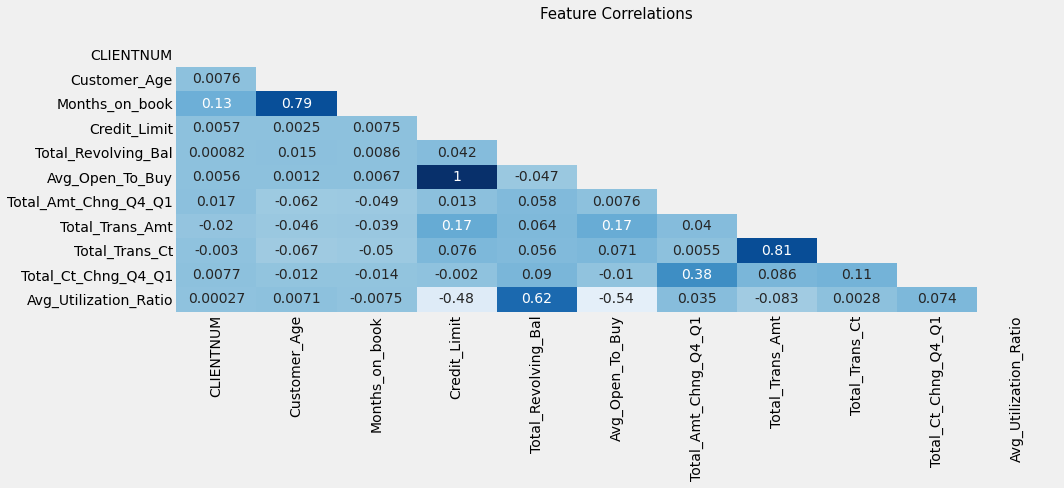

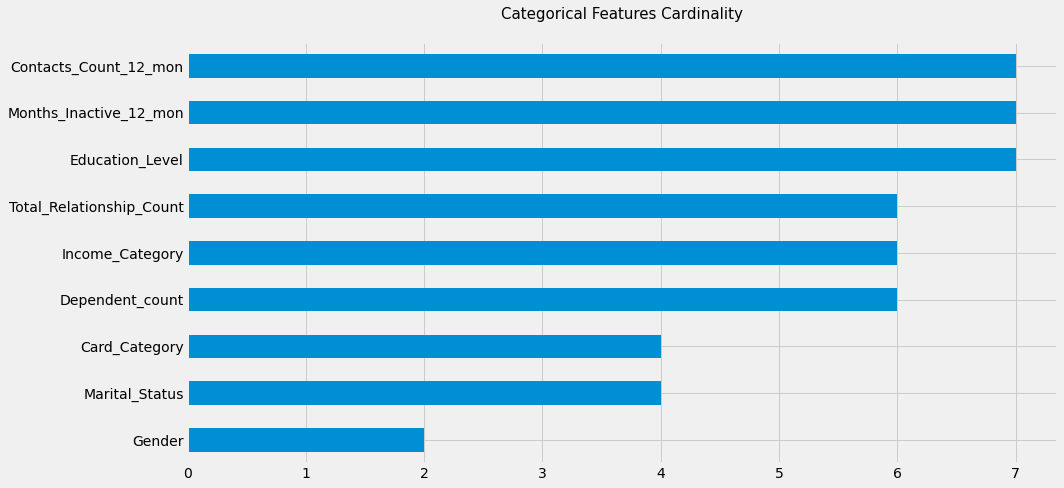

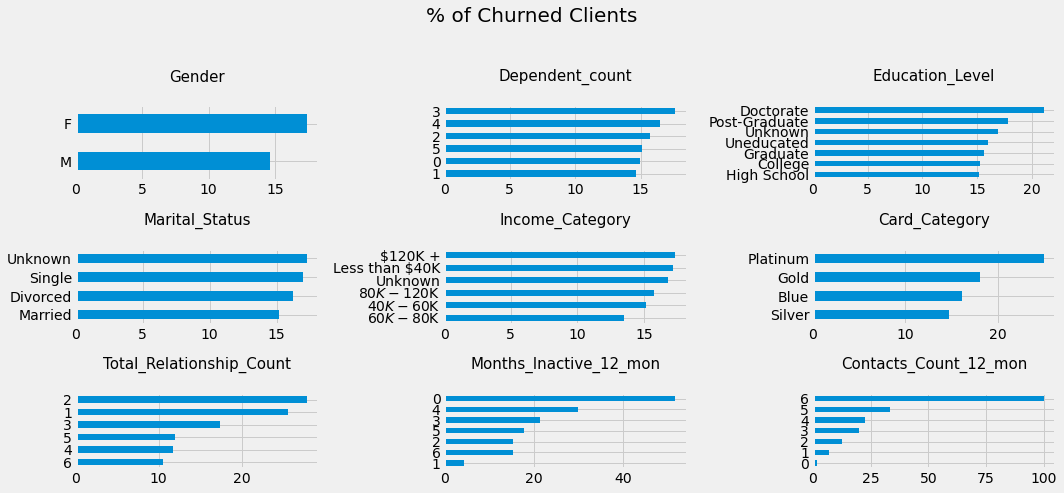

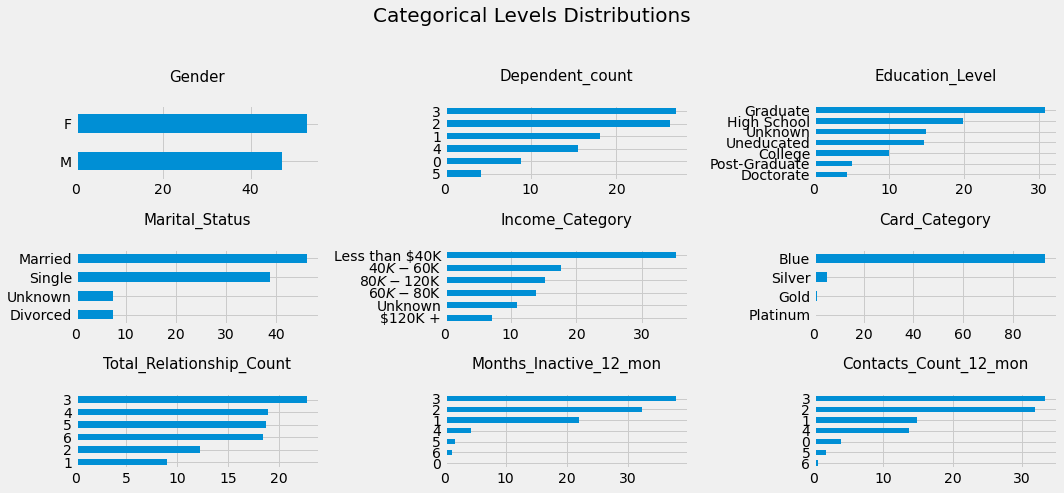

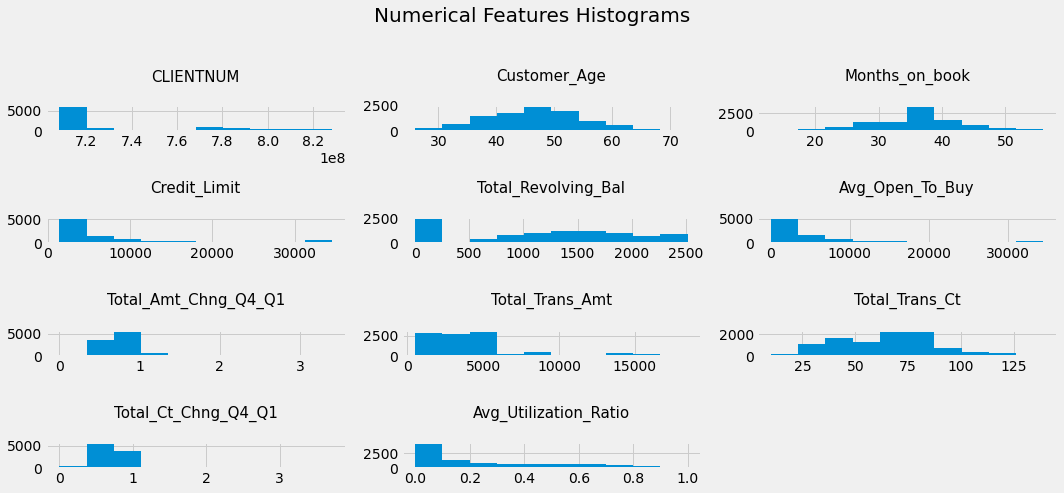

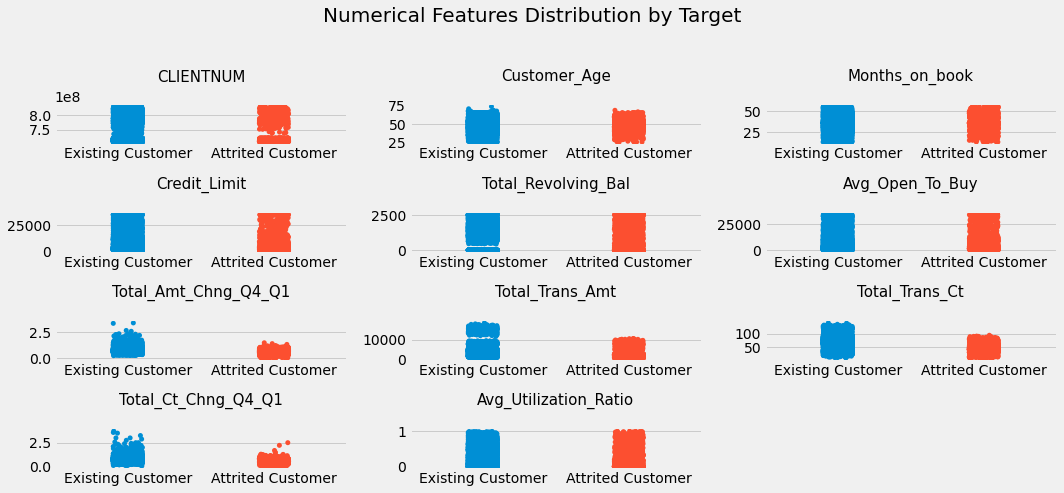

In [6]:
run_eda()